In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import cv2

from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.ticker import PercentFormatter

from numpy import mean
from numpy import std

## PCA, FA

#### AutoMPG dataset

In [2]:
# load AutoMPG dataset

#讀取.txt資料到array
array = []
f = open('auto-mpg.data.txt')
data = f.readlines()
for i in range(len(data)):
    array_list = []
    for j in data[i].split():
        array_list.append(j)
    array.append(array_list)        
#另存car name欄位資料
car_list = []
for i in data:
    i = i.split("\"")
    car_list.append(i[1])
#DataFrame
car = pd.DataFrame(car_list, columns= ['car name'])
AutoData = pd.DataFrame(array)

del_col = [0,8,9,10,11,12,13]
AutoData.drop(AutoData.columns[del_col], axis=1, inplace=True)

#合併所有資料、rename
AutoData = pd.concat([car, AutoData],axis=1)
AutoData.set_index('car name', inplace=True)
AutoData = AutoData.set_axis(['cylinders', 'displacement', 'horsepower', 
                              'weight', 'acceleration', 'model year', 'origin'],axis=1, inplace=False)

#填補遺失值
mean_hp = pd.to_numeric(AutoData['horsepower'], errors='coerce').mean()
AutoData['horsepower'] = pd.to_numeric(AutoData['horsepower'], errors='coerce').fillna(mean_hp)
#print(AutoData2)

In [3]:
#標準化
AutoData = StandardScaler().fit_transform(AutoData)

In [4]:
def pca_analysis(X, isCorrMX=True):
    # compute correlation or covariance matrix
    if isCorrMX:
        c = np.corrcoef(X, rowvar=False)
    else:
        c = np.cov(X, rowvar=False)

    eigvals, eigvecs = np.linalg.eig(c)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    loadings = eigvecs
    scores = X.dot(loadings)
    scree = np.cumsum(eigvals) / np.sum(eigvals)
    
    return loadings, eigvals, scores

def fa_analysis(X, isCorrMX=True):
    # compute the loading matrix A
    loadings, eigvals, scores = pca_analysis(X, isCorrMX)
    loadings = loadings[:, :2]

    # compute the factor matrix F
    F = X.dot(loadings)

    # compute the communality vector of h_i^2
    h2 = np.sum(loadings**2, axis=1)

    # compute the uniqueness vector of psi_i
    psi = 1 - h2
    
    # compute the vector of the proportions of total variance contributed by the ith factor
    prop_var = eigvals[:] / np.sum(eigvals)
    
    #plot
    pareto_df = pd.DataFrame({"Factor variance":eigvals})
    cur_index = list(pareto_df.index)
    for i in range(len(cur_index)):
        cur_index[i] = "Factor"+str(i+1)
    pareto_df.index = cur_index
    pareto_df = pareto_df.sort_values(by='Factor variance', ascending=False)
    pareto_df['cum portion'] = pareto_df["Factor variance"].cumsum()/pareto_df["Factor variance"].sum()*100
    cum_contribution = np.array(pareto_df['cum portion'])
    fig, ax = plt.subplots()
    ax.bar(pareto_df.index, pareto_df["Factor variance"], color="steelblue")
    ax.set_ylim(ymin=0)
    
    ax2 = ax.twinx()
    ax2.plot(pareto_df.index, pareto_df['cum portion'], color="red", marker="o", ms=4)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylim(ymin=0)
    ax.tick_params(axis='y', colors="steelblue")
    ax2.tick_params(axis='y', colors="red")
    
    # print the results
    print("When isCorrMX = ", isCorrMX, "and Standardized")
    print("loading matrix A:\n", loadings, "\n")
    print("factor matrix F:\n", F, "\n")
    print("communality vector of h𝑖^2:\n", h2, "\n")
    print("uniqueness vector of 𝜓𝑖:\n", psi, "\n")
    print("vector of the proportions of total variance contributed by the ith factor:\n", prop_var, "\n")

    return loadings, F, prop_var

When isCorrMX =  True and Standardized
loading matrix A:
 [[ 0.43862683  0.11407739]
 [ 0.45396453  0.10535161]
 [ 0.43706212 -0.13929117]
 [ 0.43230831  0.20307205]
 [-0.29765673  0.48625222]
 [-0.21479741  0.63524052]
 [-0.2981132  -0.5246669 ]] 

factor matrix F:
 [[ 2.66582768e+00 -9.67827740e-01]
 [ 3.40487799e+00 -1.09500795e+00]
 [ 3.01621594e+00 -1.22259508e+00]
 [ 2.84558047e+00 -1.06093052e+00]
 [ 2.89258892e+00 -1.28742374e+00]
 [ 4.62063326e+00 -1.24480833e+00]
 [ 5.09636495e+00 -1.47326650e+00]
 [ 5.01062413e+00 -1.56753259e+00]
 [ 5.08622236e+00 -1.29691491e+00]
 [ 4.27011580e+00 -1.63776580e+00]
 [ 3.70167426e+00 -1.37591380e+00]
 [ 3.63932494e+00 -1.72495546e+00]
 [ 3.70190152e+00 -1.32642910e+00]
 [ 4.40180948e+00 -1.61841030e+00]
 [-1.26071190e+00 -2.35700170e+00]
 [ 5.52105523e-01 -6.27799453e-01]
 [ 5.49219771e-01 -6.48255838e-01]
 [ 2.66487145e-01 -5.60056743e-01]
 [-1.48031076e+00 -2.49400924e+00]
 [-2.38853350e+00 -6.97231436e-01]
 [-1.11012446e+00 -1.16245152e+0

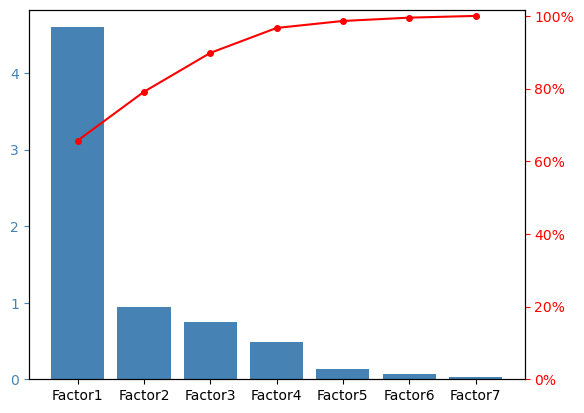

In [5]:
fa_loadings, F, prop_var = fa_analysis(X=AutoData, isCorrMX=True)

結果解釋：

Loading Matrix：每一個element $a_{ij}$ 表示第i個factor對$X_j$的影響程度

communality vector of h𝑖^2：兩兩factors之間的關聯程度

Communality Matrix：挑選的factor解釋了$X_j$的多少變異，大部分factor1可以涵蓋大部分的資料特性

uniqueness vector of 𝜓𝑖：資料中的noise

vector of the proportions of total variance contributed by the ith factor：表示從factor1~factor i 解釋了幾%的total variance，其中前兩項分別代表factor1、2，可解釋79.12%的資料(0.65+0.13)

In [6]:
# # Plot PCA variable scores
# plt.scatter(scores[:, 0], scores[:, 1])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PCA Scores')
# plt.show()

根據scatter plot或是pareto chart，可以看出PCA與FA結果相同，其中scatter plot可以觀察資料的分布狀況，PCA與FA都根據變異性將資料分成三個聚落

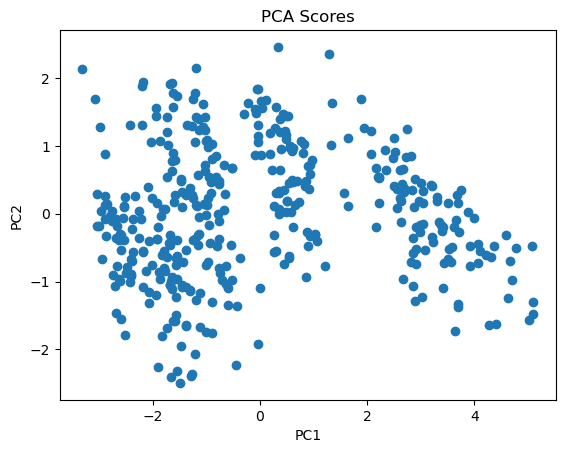

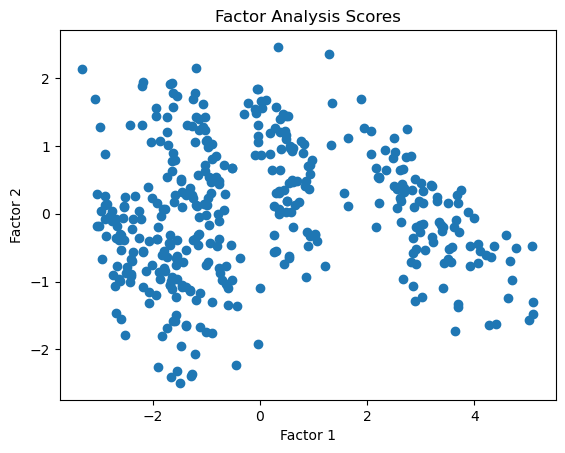

In [7]:
# Plot FA variable scores
plt.scatter(F[:, 0], F[:, 1])
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Factor Analysis Scores')
plt.show()

#### ORL Faces dataset

In [8]:
#ORL Faces資料
folder = '/Users/nuo/Documents/DA/HW2/ORL Faces'

#判斷性別
def gender(g):
    if g in [1, 8, 10, 32]:
        return 0
    else:
        return 1
    
#讀檔、建立矩陣
def order():
    pic = []
    gender_list = []
    #按照順序讀取圖片
    for i in range(1, 41):
        for j in range(1, 11):
            img = cv2.imread(folder + '/' + str(i) + '_' + str(j) + '.png', 0)
            pic.append(img)
            gender_list.append(gender(i))      
    #將性別資料加入原先矩陣中     
    arr = np.array(pic)
    arr = arr.reshape(400, 2576)
    arr = pd.DataFrame(arr)
    arr['gender'] = [g for g in gender_list]   
    return arr

#輸出結果
result = order()
ORLdata = result.drop(columns = 'gender')
#dfQ2 = StandardScaler().fit_transform(dfQ2)
ORLdata = ORLdata.T

When isCorrMX =  True and Standardized
loading matrix A:
 [[-3.35453104e-02  2.60524854e-02]
 [-4.28719957e-02  2.67190119e-03]
 [-3.78723941e-02 -4.00226794e-02]
 [-4.32823356e-02 -4.70345308e-03]
 [-4.39966070e-02 -3.87907187e-02]
 [-5.81005029e-02 -1.80558507e-02]
 [-5.13991272e-02 -3.78563091e-02]
 [-5.83063917e-02  6.17568997e-03]
 [-3.11216823e-02 -4.47075710e-02]
 [-4.58132422e-02 -3.96162317e-03]
 [-5.37852268e-02 -4.20283788e-02]
 [-5.70783740e-02 -3.67601784e-02]
 [-5.54148307e-02 -4.70134147e-02]
 [-5.60376075e-02 -4.01124150e-02]
 [-5.33729631e-02 -3.82531743e-02]
 [-5.61156548e-02 -2.70899904e-02]
 [-4.86745470e-02 -5.93656250e-02]
 [-5.34151952e-02 -5.03803408e-02]
 [-5.21953995e-02 -4.79659242e-02]
 [-5.09436539e-02 -5.29323654e-02]
 [-5.90821224e-02 -2.40532050e-04]
 [-5.44585637e-02  8.83238509e-03]
 [-5.58266879e-02 -1.44797770e-03]
 [-5.65747819e-02 -3.46932514e-02]
 [-5.11091019e-02 -4.33633947e-02]
 [-6.46231064e-02  1.87223559e-02]
 [-6.32111410e-02  1.27449807e-0

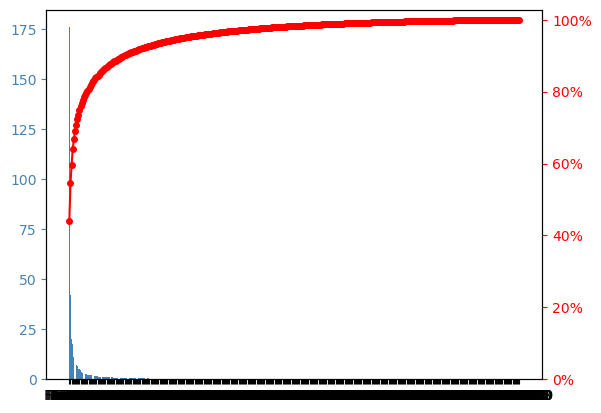

In [9]:
loadings, F, prop_var = fa_analysis(X=ORLdata, isCorrMX=True)

In [10]:
# Compute the cumulative sum of explained variance
cumulative_variances = np.cumsum(prop_var)

# Determine the number of principal components needed to explain 50%, 60%, 70%, 80%, and 90% of the total variance
n_components = [np.argmax(cumulative_variances >= j) + 1 for j in [0.5, 0.6, 0.7, 0.8, 0.9]]

print("Number of principal components needed to explain:")
print("50% of the total variance:", n_components[0])
print("60% of the total variance:", n_components[1])
print("70% of the total variance:", n_components[2])
print("80% of the total variance:", n_components[3])
print("90% of the total variance:", n_components[4])

Number of principal components needed to explain:
50% of the total variance: 2
60% of the total variance: 4
70% of the total variance: 7
80% of the total variance: 17
90% of the total variance: 50


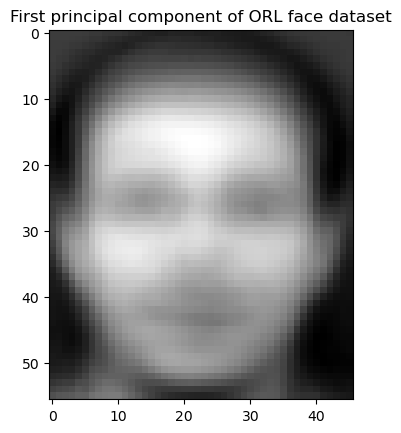

In [11]:
# rescale the first factor into the range [0, 255]
fa = F.iloc[:, 0]
fa = fa * 255 / (np.max(fa))
# reshape a 46 × 56 matrix
fa = fa.values.reshape(56, 46)

# plot
plt.imshow(fa, cmap='gray')
plt.title("First principal component of ORL face dataset")
plt.show()

In [18]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

#讀取.txt資料到array
array = []
f = open('auto-mpg.data.txt')
data = f.readlines()
for i in range(len(data)):
    array_list = []
    for j in data[i].split():
        array_list.append(j)
    array.append(array_list)        
#另存car name欄位資料
car_list = []
for i in data:
    i = i.split("\"")
    car_list.append(i[1])
#DataFrame
car = pd.DataFrame(car_list, columns= ['car name'])
auto_df = pd.DataFrame(array)

del_col = [8, 9,10,11,12,13]
auto_df.drop(auto_df.columns[del_col], axis=1, inplace=True)

#合併所有資料、rename
auto_df = pd.concat([car, auto_df],axis=1)
auto_df.set_index('car name', inplace=True)
auto_df = auto_df.set_axis(['mpg', 'cylinders', 'displacement', 'horsepower', 
                              'weight', 'acceleration', 'model year', 'origin'],axis=1, inplace=False)

#填補遺失值
mean_hp = pd.to_numeric(auto_df['horsepower'], errors='coerce').mean()
auto_df['horsepower'] = pd.to_numeric(auto_df['horsepower'], errors='coerce').fillna(mean_hp)
#print(auto_df)

In [19]:
# Select 300 random cars for training and the rest for testing
train_df = auto_df.sample(n=300, random_state=0)
test_df = auto_df.drop(train_df.index)

# Separate X (predictors) and y (response) variables for training and testing
X_train = train_df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']]
y_train = train_df['mpg']
X_test = test_df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']]
y_test = test_df['mpg']

# Fit PLSR model with a single y variable
plsr_model = PLSRegression(n_components=2)
plsr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = plsr_model.predict(X_test)

# Evaluate the model performance
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

R-squared: 0.8011


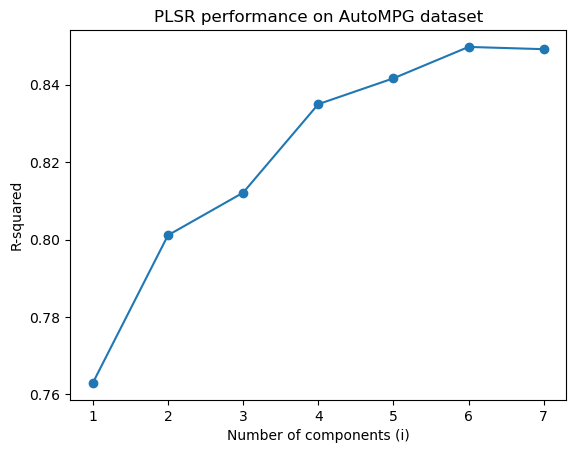

In [20]:
# Fit PLSR model with different numbers of components (i)
n_components_range = range(1, 8)
r2_scores = []
for i in n_components_range:
    plsr_model = PLSRegression(n_components=i)
    plsr_model.fit(X_train, y_train)
    y_pred = plsr_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Plot R-squared vs. number of components
plt.plot(n_components_range, r2_scores, '-o')
plt.xlabel('Number of components (i)')
plt.ylabel('R-squared')
plt.title('PLSR performance on AutoMPG dataset')
plt.show()

使用R-squared檢測PLSR模型好壞。

PLSR模型解釋了測試集中大約 80.11% 的mpg方差。R-squared值可能會隨著我們選擇用於訓練的 300 輛汽車的隨機樣本而有所不同。


根據上圖，n_components增加，R-squared增加，n_components=6有最大R-squared

In [21]:
# Separate X (predictors) and y (response) variables for training and testing
X_train = train_df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']]
y_train = train_df[['mpg', 'model year']]
X_test = test_df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']]
y_test = test_df[['mpg', 'model year']]

# Fit PLSR model with a single y variable
plsr_model = PLSRegression(n_components=2)
plsr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = plsr_model.predict(X_test)

# Evaluate the model performance
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

R-squared: 0.8934


增加model year作為y變量提高R-squared。n_components調整後，與a.有不同結論，在n_components=2之後，R-squared上升幅度不大。

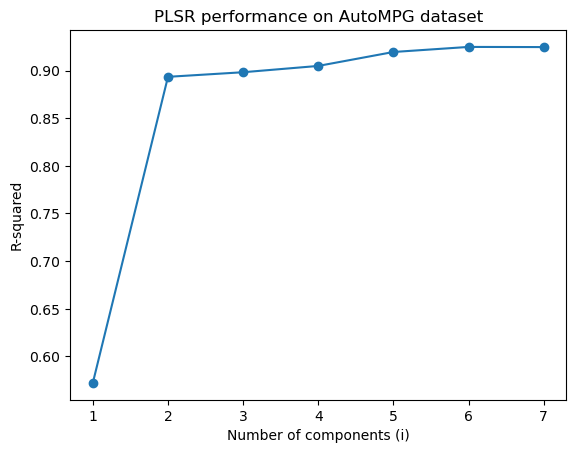

In [22]:
# Fit PLSR model with different numbers of components (i)
n_components_range = range(1, 8)
r2_scores = []
for i in n_components_range:
    plsr_model = PLSRegression(n_components=i)
    plsr_model.fit(X_train, y_train)
    y_pred = plsr_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Plot R-squared vs. number of components
plt.plot(n_components_range, r2_scores, '-o')
plt.xlabel('Number of components (i)')
plt.ylabel('R-squared')
plt.title('PLSR performance on AutoMPG dataset')
plt.show()